<a href="https://colab.research.google.com/github/davidsjohnson/xai_ac_sose25/blob/main/notebooks/exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI for Affective Computing (SoSe2025)
# Exercise 1: Global Explanations of Facial Expression Recognition with Action Units
# 

In this notebook you will attempt to generate global explanations for predictions of an XGBoost facial expression recognition (FER) model trained with tabular (structured) data extracted from images using a subset of the [AffectNet dataset](http://mohammadmahoor.com/affectnet/). AffectNet is an image dataset of facial expressions in the wild, and is labeled with 8 facial expression categories: **Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, and Contempt**. (Have a look at the paper for more details https://arxiv.org/abs/1708.03985).

To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.


***NOTE**: If using Google Colab, you can use a CPU only runtime as the model is implemented for GPU acceleration*

## Notebook Setup

Make sure to uncomment code based on if you are running locally or via Google Colab

In [1]:
## uncomment and run this cell to use Google Colab
# !git clone https://github.com/davidsjohnson/wise24_xai_ac.git
# fix xgboost incompatiblity issue
# %pip uninstall -y -q scikit-learn
# %pip install -q scikit-learn==1.5.2

In [2]:
import sys
import os
sys.path.append(os.path.realpath('../'))  # uncomment this line if you are running this notebook locally
# sys.path.append(os.path.realpath('wise24_xai_ac')) # uncomment this line if you are running this notebook on Google Colab

In [3]:
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
import seaborn as sns

from skimage import io

import utils
import img_utils

In [4]:
colab = False # change to False if running locally
base_dir = Path('../data/') if not colab else Path('wise24_xai_ac/data/')

In [5]:
affnet_dir = utils.download_file('https://uni-bielefeld.sciebo.de/s/EmfF9r93LG4jcT9/download', 
                          file_name='affectnet_data.zip', 
                          cache_dir=base_dir,
                          extract=True,
                          force_download=True,
                          archive_folder='affectnet_data')
affnet_dir

File downloaded to: ../data/affectnet_data.zip


PosixPath('../data/affectnet_data')

## Data Loading

### Loading Images and Action Units

In the next cell, you will load csv files that contain extracted actions units and paths to the corresponding images.  

In [6]:

# Full data from training and evaluation
train_csv = affnet_dir / 'affectnet_aus/train_aus.csv'
val_csv = affnet_dir / 'affectnet_aus/val_aus.csv'

# load training and validation data as pandas dataframes
# action units extracted from the AffectNet dataset via OpenFace
df_train = pd.read_csv(train_csv)
df_val = pd.read_csv(val_csv)

# smaller dataset for explanations
xai_csv = affnet_dir / 'affectnet_aus/eval_aus.csv'
df_xai = pd.read_csv(xai_csv)
df_xai['image'] = df_xai['image'].str.replace('../data', str(affnet_dir))

# get the class labels
class_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']  # same class labels as before

# Gets all images from folder used for XAI tasks
images = [io.imread(f) for f in df_xai.image]

/var/folders/cn/w2dpgz0941bcbfg3wgqzyr6c0000gn/T/ipykernel_20333/570637544.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_xai['image'] = df_xai['image'].str.replace('../data', str(affnet_dir))


Here is a feature name map to make AUs values easier to Read in Shap Plots

In [7]:
# Mapping of Action Units (AUs) to their names
AU_MAP = {
    "AU01": "Inner Brow Raiser",
    "AU02": "Outer Brow Raiser",
    "AU04": "Brow Lowerer",
    "AU05": "Upper Lid Raiser",
    "AU06": "Cheek Raiser",
    "AU07": "Lid Tightener",
    "AU09": "Nose Wrinkler",
    "AU10": "Upper Lip Raiser",
    "AU12": "Lip Corner Puller",
    "AU14": "Dimpler",
    "AU15": "Lip Corner Depressor",
    "AU17": "Chin Raiser",
    "AU20": "Lip Stretcher",
    "AU23": "Lip Tightener",
    "AU25": "Lips Part",
    "AU26": "Jaw Drop",
    "AU28": "Lip Suck",
    "AU45": "Blink",
}

# Generate mappings for both 'r' (regression) and 'c' (classification) versions
AU_FEATURE_MAP = {f"{au}_r": f"{au} - {name} - R" for au, name in AU_MAP.items()}
AU_FEATURE_MAP.update({f"{au}_c": f"{au} - {name} - C" for au, name in AU_MAP.items()})

# Print the mapping
print(AU_FEATURE_MAP)

{'AU01_r': 'AU01 - Inner Brow Raiser - R', 'AU02_r': 'AU02 - Outer Brow Raiser - R', 'AU04_r': 'AU04 - Brow Lowerer - R', 'AU05_r': 'AU05 - Upper Lid Raiser - R', 'AU06_r': 'AU06 - Cheek Raiser - R', 'AU07_r': 'AU07 - Lid Tightener - R', 'AU09_r': 'AU09 - Nose Wrinkler - R', 'AU10_r': 'AU10 - Upper Lip Raiser - R', 'AU12_r': 'AU12 - Lip Corner Puller - R', 'AU14_r': 'AU14 - Dimpler - R', 'AU15_r': 'AU15 - Lip Corner Depressor - R', 'AU17_r': 'AU17 - Chin Raiser - R', 'AU20_r': 'AU20 - Lip Stretcher - R', 'AU23_r': 'AU23 - Lip Tightener - R', 'AU25_r': 'AU25 - Lips Part - R', 'AU26_r': 'AU26 - Jaw Drop - R', 'AU28_r': 'AU28 - Lip Suck - R', 'AU45_r': 'AU45 - Blink - R', 'AU01_c': 'AU01 - Inner Brow Raiser - C', 'AU02_c': 'AU02 - Outer Brow Raiser - C', 'AU04_c': 'AU04 - Brow Lowerer - C', 'AU05_c': 'AU05 - Upper Lid Raiser - C', 'AU06_c': 'AU06 - Cheek Raiser - C', 'AU07_c': 'AU07 - Lid Tightener - C', 'AU09_c': 'AU09 - Nose Wrinkler - C', 'AU10_c': 'AU10 - Upper Lip Raiser - C', 'AU12_

In [8]:
# update the feature names in the dataframe
df_train.rename(columns=AU_FEATURE_MAP, inplace=True)
df_val.rename(columns=AU_FEATURE_MAP, inplace=True)
df_xai.rename(columns=AU_FEATURE_MAP, inplace=True)

In [9]:
# get only the columns storing action units from the dataframe
# there are also facial landmarks and other features in the dataset could be useful
# but we igore them for now and focus on action units
feature_names = [col for col in df_val.columns if col.startswith('AU')]
numerical_features = [feat for feat in feature_names if '- R' in feat]
numerical_idxs = [i for i, feat in enumerate(feature_names) if '- R' in feat]
categorical_features = [feat for feat in feature_names if '- C' in feat]
categorical_idxs = [i for i, feat in enumerate(feature_names) if '- C' in feat]

## Train the XGBoost Model
In this part, we will generate explanations for the XGBoost model trained using a dataset of Facial Action Units (as described in the notebook introduction).  

First, let's load the data and the trained models. Then we will evaluate the model peformance, before we start with the explanations.

In [10]:
from xgboost import XGBClassifier

### Setup the Datasets

In [11]:
# we will only use numerical features to remove collinearity
X_train = df_train[numerical_features]
y_train = df_train['class']
X_test = df_val[numerical_features]
y_test = df_val['class']

X_xai = df_xai[numerical_features]
y_xai = df_xai['class']

print('Training data shape:', X_train.shape, y_train.shape)
print('Test data shape:', X_test.shape, y_test.shape)
print('XAI data shape:', X_xai.shape, y_xai.shape)

Training data shape: (36685, 17) (36685,)
Test data shape: (3908, 17) (3908,)
XAI data shape: (80, 17) (80,)


### Train the Model

Now let's train the XGBoost Model on the split dataset. The accuracy of the model on the training data should be around $99\%$

In [12]:
# # Train model from scratch
random_state = 10
clf = XGBClassifier(max_depth=20, eta=0.1, reg_lambda=3, random_state=random_state)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9962382445141066

### Evaluate the Model

Now we will evaluate it on the test dataset. Unfortunately, the accuracy is only $40\%$ but this is still above random guessing which would be $1 / 8 * 100 = 12.5\%$ accuracy (since there are 8 total classes)

In [13]:
# get model predictions
y_test_preds = clf.predict(X_test)
y_test_true = y_test

# eval results
print(classification_report(y_test_true, y_test_preds, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.30      0.41      0.35       485
       Happy       0.55      0.65      0.59       488
         Sad       0.37      0.37      0.37       490
    Surprise       0.37      0.34      0.35       488
        Fear       0.43      0.43      0.43       487
     Disgust       0.49      0.34      0.40       493
       Anger       0.36      0.39      0.37       482
    Contempt       0.38      0.25      0.30       495

    accuracy                           0.40      3908
   macro avg       0.40      0.40      0.40      3908
weighted avg       0.40      0.40      0.40      3908



We can also review the confusion matrix to see where the model makes its mistakes

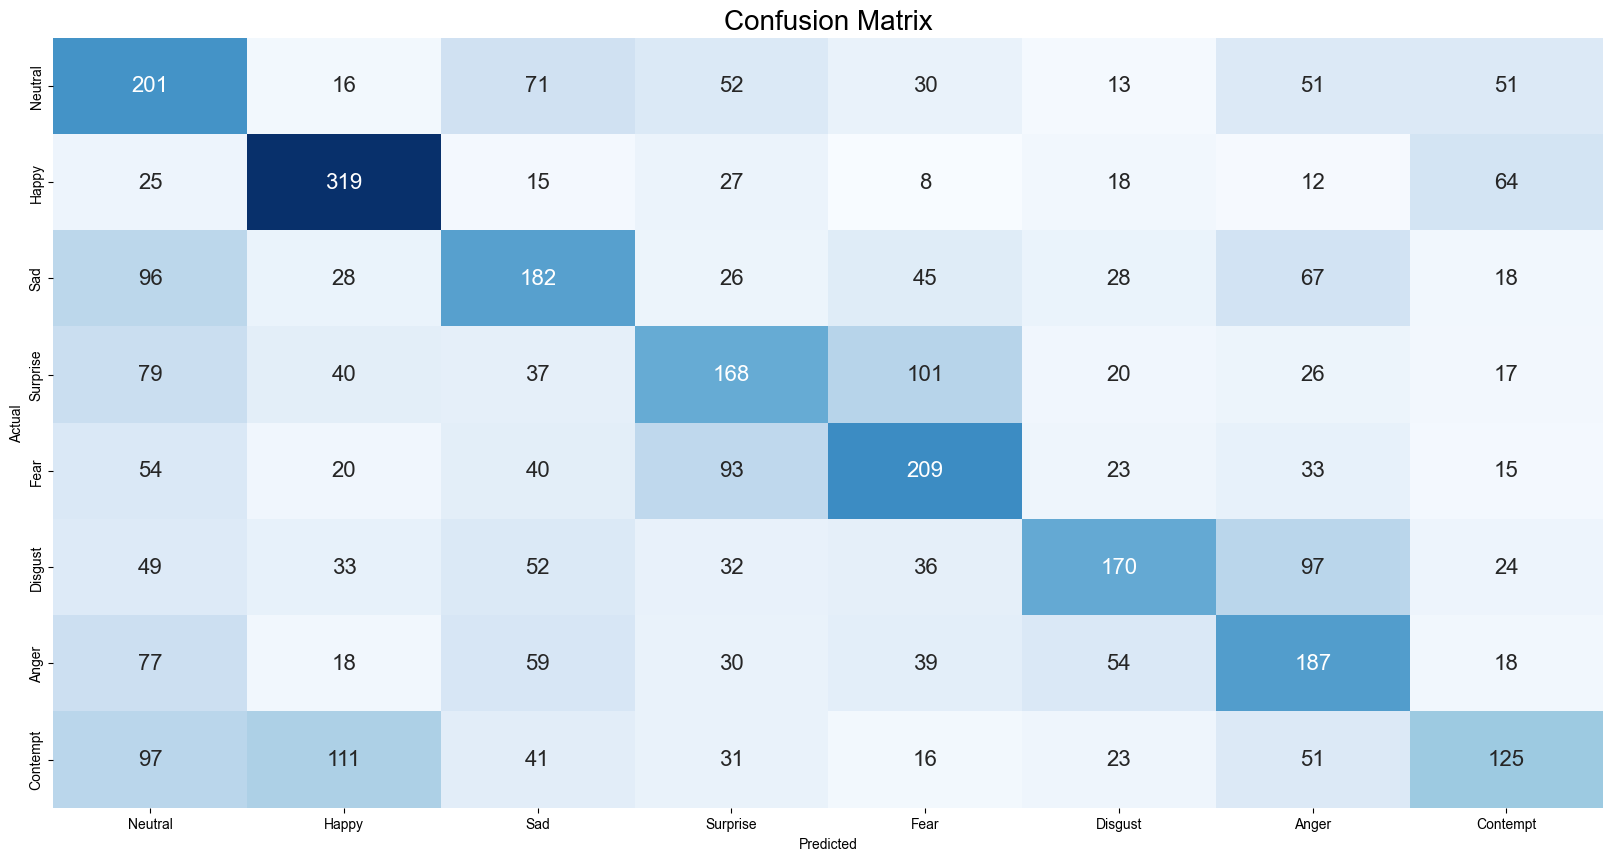

In [14]:
cm_data = confusion_matrix(y_test_true, y_test_preds)
cm = pd.DataFrame(cm_data, columns=class_names, index=class_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

### Setup XAI dataset and Predictions

In [15]:
# Evaluate model on XAI data
y_xai_preds = clf.predict(X_xai)
y_xai_true = y_xai

df_xai['xgb_pred'] = y_xai_preds

print(classification_report(y_xai_true, y_xai_preds, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.24      0.40      0.30        10
       Happy       0.64      0.70      0.67        10
         Sad       0.50      0.60      0.55        10
    Surprise       0.38      0.30      0.33        10
        Fear       0.62      0.50      0.56        10
     Disgust       0.50      0.40      0.44        10
       Anger       0.18      0.20      0.19        10
    Contempt       0.60      0.30      0.40        10

    accuracy                           0.42        80
   macro avg       0.46      0.42      0.43        80
weighted avg       0.46      0.42      0.43        80



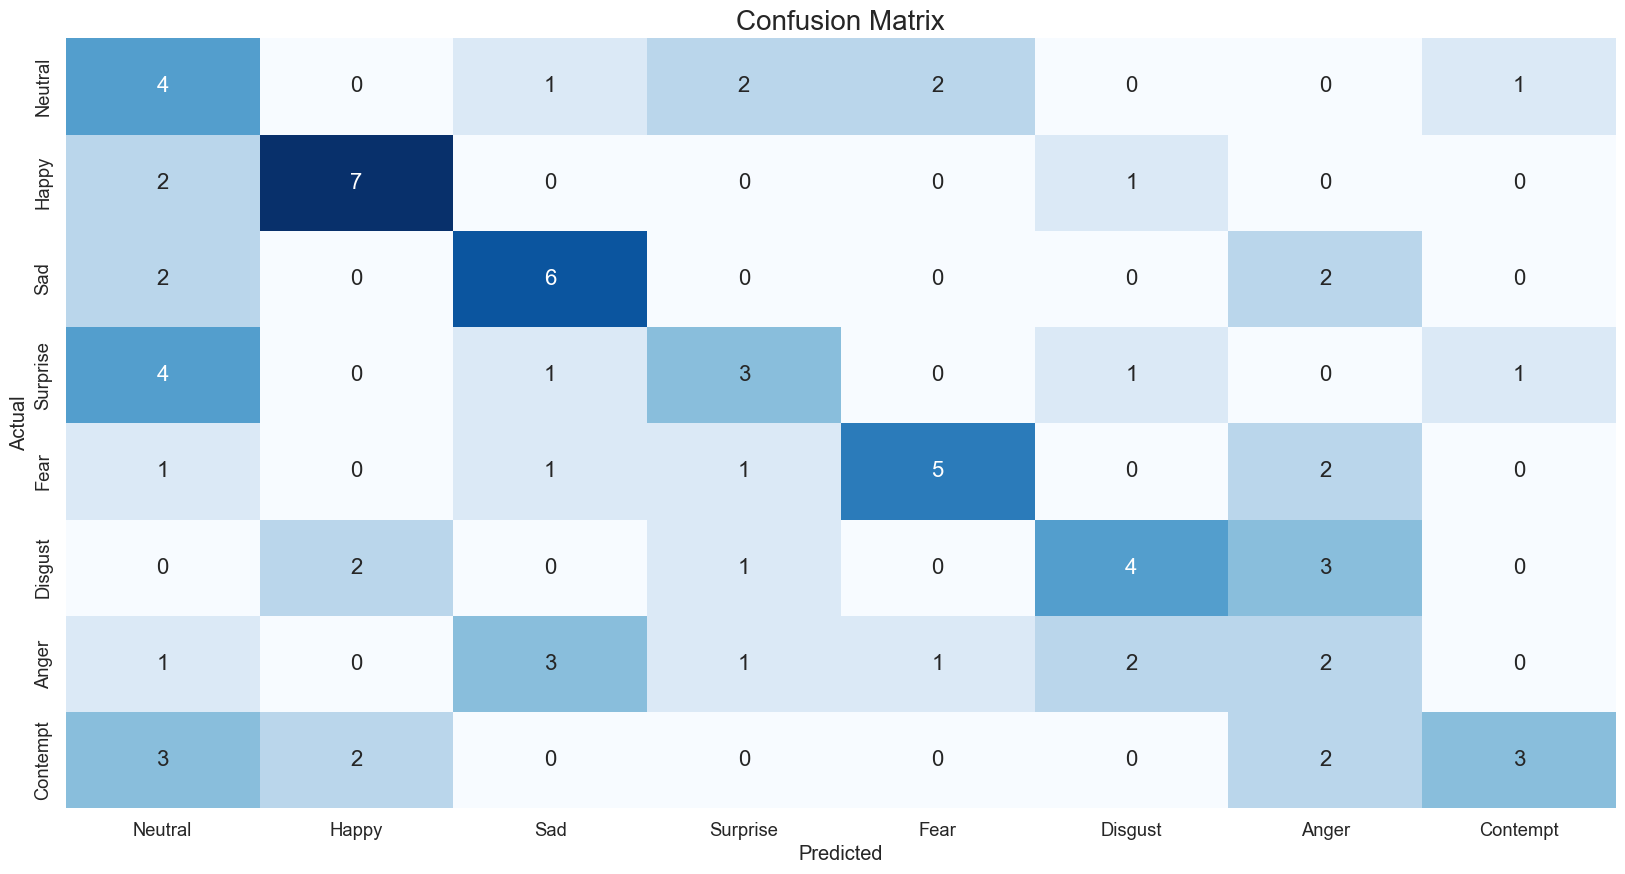

In [16]:
cm_data = confusion_matrix(y_xai_true, y_xai_preds)
cm = pd.DataFrame(cm_data, columns=class_names, index=class_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Main Tasks: Generate Global Explanations

In this exercise, we will focus on global feature importance explanations, to try to better understand how the model makes predictions. Review each of the individual tasks for different approaches at global understanding.  


### Task 1: Generate XGBoost Explanations

Our XGBoost model has builtin feature imporantance values (when using a tree-based model) that show overall feature importances for the model based on the generated trees.

- You can see the main example here: https://xgboost.readthedocs.io/en/release_2.0.0/python/python_intro.html#plotting 
- And the full API here: https://xgboost.readthedocs.io/en/release_2.0.0/python/python_api.html#xgboost.plot_importance

In this task, plot the feature importance values directly using XGBoost. Then answer the questions below.

In [17]:
import xgboost as xgb

In [ ]:
##### Your Code Here #####


#### Task questions

1. The `plot_importance` function has an argument `importance_type`. What are the available types and how do they calcuate feature importance values? Are the feature importances created with each importance types consistent?
2. What are the main insights about the model that you have learned from this plot?

Answer here....

### Task 2: Train an Interpretable Models

In the previous task, we saw that XGBoost's feature importance values, may not always be consistent. Instead, let's trying training and interpretable (aka GlassBox) model. For this we can use an Explainable Boosting Machine (EBM) from Microsofts [InterpretML library](https://interpret.ml/).

In this task, you should train a EBM model using the library's documentation as a guide: https://interpret.ml/docs/ebm.html. After training, output the model's results on the training data and the XAI dataset (similar to the XGBoost results above).  The training data will not have as good of results as the XGBoost model, but the test data should be fairly comparable.  

Then plot the global explanations from the model. 

After this answer the questions below.  

In [21]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show 

In [ ]:
##### Your Code Here #####

#### Task Questions
1. Are these feature importance values more reliable than the feature importance values from XGBoost? Why or why not?
2. Explain the performance-interpretability tradeoff. Is it worth it in this case, to have use an inherently interpretable model?
3. What interesting insights did you learn from exploring the explanation interface?

Answer here...

### Task 3: Partial Dependency Plots

Partial Dependency Plots (PDP) are another type of global explanation that explain the marginal effect of one or two features on the predicted outcome of a model.  Read about them here: https://christophm.github.io/interpretable-ml-book/pdp.html. 

In this task, you will create PDPs using the Scikit-Learn implementation: https://scikit-learn.org/stable/modules/partial_dependence.html  



For this task, we will use the XGBoost model again. 

- Select three classes from the AffectNet dataset and generate 4 to 6 PDPs for each of the classes
- Since PDP doesn't offer a summary of all the features, you can choose which features you create plots for.
- To help find interesting AUs for each class, review the "Emotions and Action Units" section of the iMotions descriptions on the Facial Action Coding system: https://imotions.com/blog/learning/research-fundamentals/facial-action-coding-system/

Then answer the task questions below.

In [36]:
from sklearn.inspection import PartialDependenceDisplay

In [34]:
##### Your Code Here #####

#### Task Questions

1. What do the PDPs tell you about the relationship of a given AU to the model's predicted output?
2. What major insights did you find reviewing the PDPs for the different classes?  Do the results align with the provided AUs for each emotion from the iMotions website? Was there anything surprising?
3. What assumption do PDPs make about feature independence? How feature colinearity affect the reliability of PDP interpretations?


### Task 4: Read about XGBoost Global Explanations
In preperation for the next exercise with SHAP, read about feature importance values from XGBoost and the SHAP approach to address some of the downsides. https://medium.com/data-science/interpretable-machine-learning-with-xgboost-9ec80d148d27
